Introduction:
===

In this notebook we'll attempt to train a custom UNET to complete EFB vocalizations -- the input being 'half' of a bat squeak, and the target being the reconstruction of the completed vocalization sample. Just for fun, we'll also carry over the positional encoding layer and use it in our model. 

In [1]:
from fastai.vision.all import *
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import umap
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/google/colab/data_table.py:30: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils import traitlets as _traitlets


We'll train off of the full sized dataset of annotated vocalizations, transformed into the CQ representation of the audio (a dataset of images rather than audio files, to shave of training time). We won't be using the annotations, nor the full 80k files, just more data than previously worked with. 

In [96]:
dest_path = "/home/jupyter/data/"
path = Path("{}egyptian_fruit_bat_annotated_cqt".format(dest_path))
files = [str(x) for x in get_image_files(path)]

print("Found {} squeaks!".format(len(files)))
files[0]

Found 87987 squeaks!


'/home/jupyter/data/egyptian_fruit_bat_annotated_cqt/files210/121227051825491476.png'

In [6]:
def get_x(p):
    #returns a gs numpy array
    return np.array(Image.open(p))[:, :, 0]

def get_items(p):
    return get_image_files(p)[:16000]#just going to use a smaller amount of the data

The function `pos_enc2d_layer()` takes a tensor of shape `[bs, 1, w, h]` and transforms it into a tensor of shape `[bs, n, w, h]` (where `n` is the number of segments you wish to cut the images into) Each segment contains a vertical region that is roughly `1/n` of the size original image. 

In [7]:
def constrain(x, a, b):
        if x > b: return b
        if x < a: return a
        else: return x
        
def make_mask(shape, start, end):
        #returns a vertical mask:
        block_0 = np.zeros((shape[1], start))
        block_1 = np.ones((shape[1], end - start))
        block_2 = np.zeros((shape[1], constrain(shape[0] - end, 0, shape[0])))
        mask = np.block([block_0, block_1, block_2])
        
        if mask.shape != shape:
            return mask[:shape[1], :shape[1]]
        else: return mask
        
def pos_enc2d_np(gs_im, out_c = 5, eta = 0.05):

    window_widths = np.random.uniform((1/(out_c-2)) - eta, 
                                      (1/(out_c-2)) + eta, out_c)
    window_widths = np.round(window_widths*gs_im.shape[0]).astype(np.uint8)   
    
    window_starts = np.random.uniform((1/out_c) - eta, 
                                      (1/out_c) + eta, out_c)
    
    window_starts = np.array([sum(window_starts[0:i]) for i in range(out_c)])
    window_starts = np.round(window_starts*gs_im.shape[0]).astype(np.uint8)   
    new_ims = []
    
    for i in range(out_c):
        if i < out_c:
            temp_mask = make_mask(gs_im.shape, 
                                  start = window_starts[i], 
                                  end = window_starts[i] + window_widths[i])
        if i == out_c:
            #making sure the last mask gets the last of the image:
            temp_mask = make_mask(gs_im.shape, 
                                  start = int(gs_im.shape[0]*out_c), 
                                  end = gs_im.shape[0])

        new_ims.append(np.multiply(temp_mask, gs_im))
    return np.dstack(new_ims)   

def pos_enc2d_layer(tensor, out_c = 6, eta = 0.05):
    #adapting the pos_enc2d to act as a layer in the model:
    bs, channels, h, w = tensor.shape
    assert channels == 1, "Input should have one channel!"
    np_tensor = np.array(tensor.cpu()) #a little hacky! probably could be better!
    stack = [pos_enc2d_np(np_tensor[i,:, :, :].reshape(h, w), out_c, eta) for i in range(bs)]
    stack  = np.array(stack).reshape(bs, out_c, h, w)
    return torch.from_numpy(stack).type(torch.cuda.FloatTensor)

a = torch.from_numpy(np.random.rand(1, 1, 100, 100))
print(a.shape)
print(pos_enc2d_layer(a).shape)

torch.Size([1, 1, 100, 100])
torch.Size([1, 6, 100, 100])


The function `get_crop_x()` just cuts out the last half of the provided image (with some randomization thanks to the parameter `eta`). The idea here is that we want to only give the model the first bit of a vocalization, so that it can try to learn the next 'phrase' given an initial squeak.

In [12]:
def get_crop_x(p, ratio = 0.5, eta = 0.15):
    im = get_x(p)
    end = int((np.random.uniform(-eta, eta)+ratio)*im.shape[0])
    mask = make_mask(im.shape, start = 0, end = end)
    return np.multiply(im, mask)

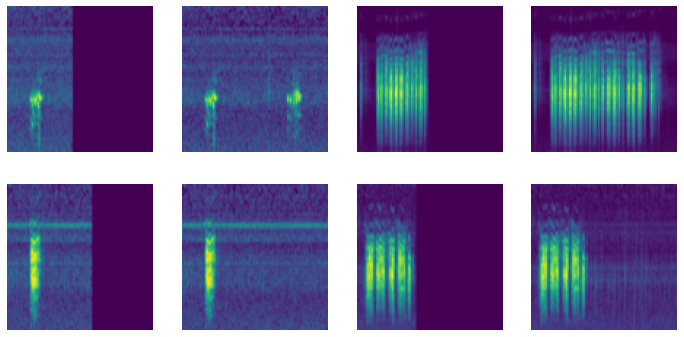

In [19]:
#using a small batch size bc my instance will crash if I don't
size = 100
bs =  4
dls = DataBlock(blocks = (ImageBlock, ImageBlock), 
                get_items = get_items, 
                get_x = get_crop_x, 
                get_y = get_x,
                item_tfms = Resize((size, size), method = "squish"),
                splitter = RandomSplitter(seed=42)).dataloaders(path, 
                                                                 bs = bs)
dls.show_batch()

In [89]:
#quick callback so that I can make the long training process 
#a little more visually stimulating!

from PIL import Image
class Output_Callback(Callback):
    def __init__(self, learner):
        self.model = learner.model
        self.good_indices = [21, 19, 17] #file indices that are visually 'good'
        self.n_pics = len(self.good_indices)
        self.test_ims = [Image.open(files[i]).reshape(size, size) for i in self.good_indices]
        self.test_ims = [(np.array(im)[:, :, 0]).astype("float32") for im in self.test_ims]
        
    def after_epoch(self):
        
        fig, axs = plt.subplots(self.n_pics, 2, figsize = (8, 8))
        
        for i in range(self.n_pics):                
                axs[i, 0].imshow(self.test_ims[i])
                axs[i, 0].axis("off")
                
                temp_torch_im = torch.from_numpy(self.test_ims[i].reshape(1, 1, size, size))
                pred_im = self.model.forward(temp_torch_im).cpu().detach().view(size, size)
                axs[i, -1].imshow(pred_im)
                axs[i, -1].axis("off")
            
        plt.tight_layout()
        plt.show()
            

In [90]:
class custom_unet(Module):
    def __init__(self):
        super().__init__()
        
        #a simple unet sandwiched between conv layers so that we
        #can use the custom positional encoding layer.
        
        self.in_c = 5
        m = resnet18()
        m = nn.Sequential(*list(m.children())[:-2])
        
        self.encoder_head = nn.Sequential(
                                    nn.Conv2d(in_channels = self.in_c,     
                                             out_channels = 3, 
                                             kernel_size = (5, 5), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias = True),
                                    nn.ReLU(inplace = True))
        
        self.unet = DynamicUnet(m, 3, (size, size), norm_type=None)
        
        self.fix_final_shape = nn.Sequential(
                                    nn.Conv2d(in_channels = 3,     
                                             out_channels = 6, 
                                             kernel_size = (5, 5), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias = True),
                                    nn.ReLU(inplace = True),
                                    nn.Conv2d(in_channels = 6,     
                                             out_channels = 6, 
                                             kernel_size = (5, 5), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias = True),
                                    nn.ReLU(inplace = True),
                                    nn.Conv2d(in_channels = 6,     
                                             out_channels = 1, 
                                             kernel_size = (5, 5), 
                                             stride = (1, 1), 
                                             padding = (1, 1), 
                                             bias = True),
                                    nn.ReLU(inplace = True),
                                    nn.AdaptiveMaxPool2d(output_size = (size, size)))
        
        
    def forward(self, x):
        x = pos_enc2d_layer(x, out_c = self.in_c)
        x = self.encoder_head(x)
        x = self.unet(x)
        x = self.fix_final_shape(x)
        return x

In [92]:
cu_learner = Learner(dls, custom_unet(), loss_func=nn.MSELoss())
cb =  Output_Callback(cu_learner)
cu_learner = cu_learner.add_cb(cb)

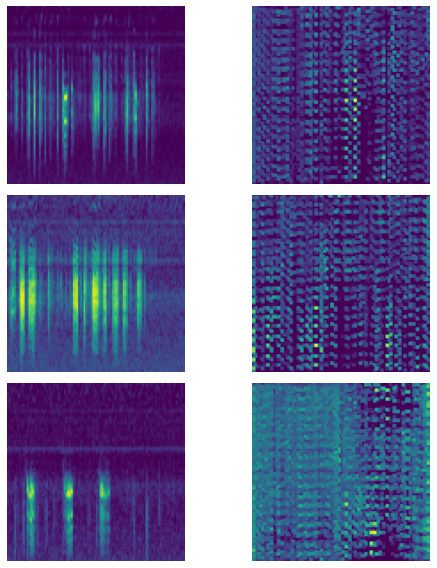

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=1.5848931980144698e-06)

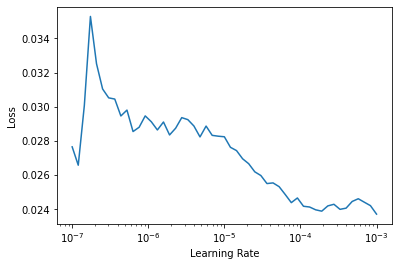

In [93]:
cu_learner.lr_find()

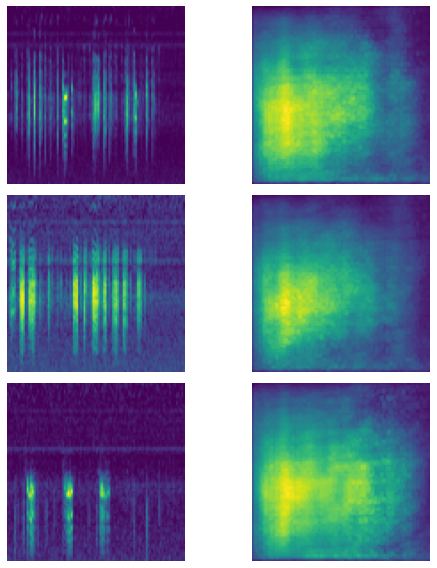

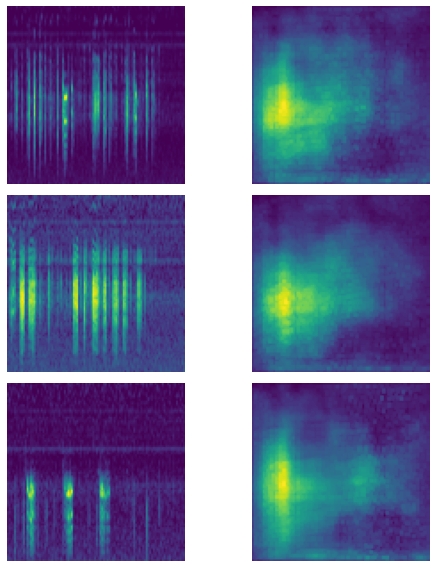

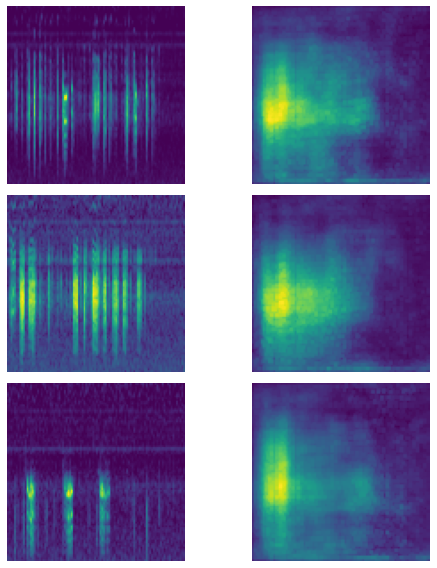

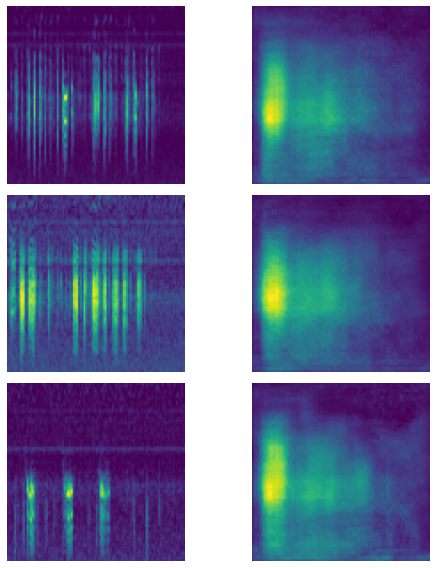

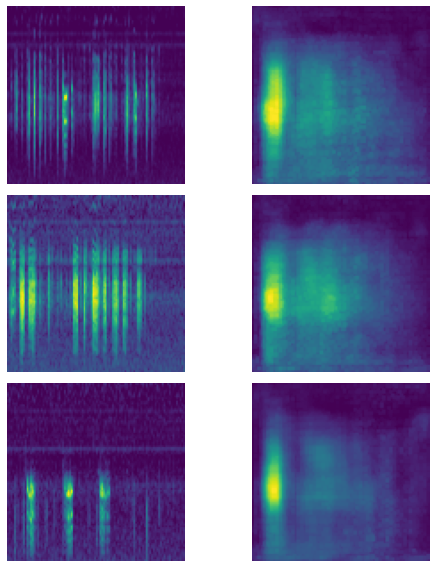

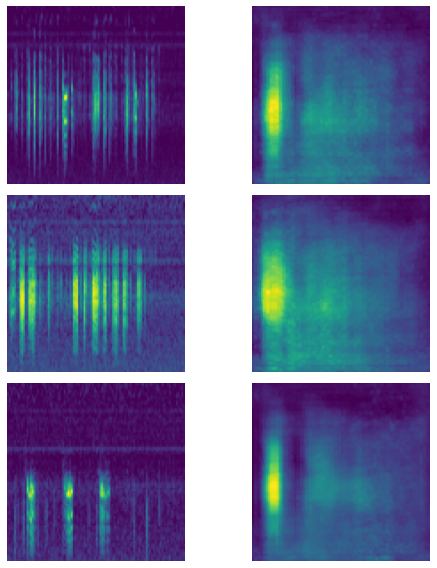

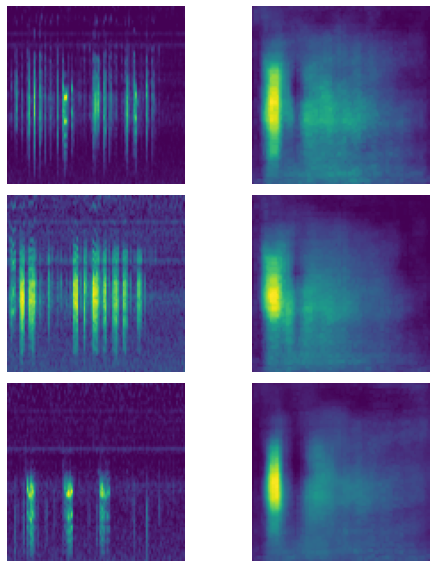

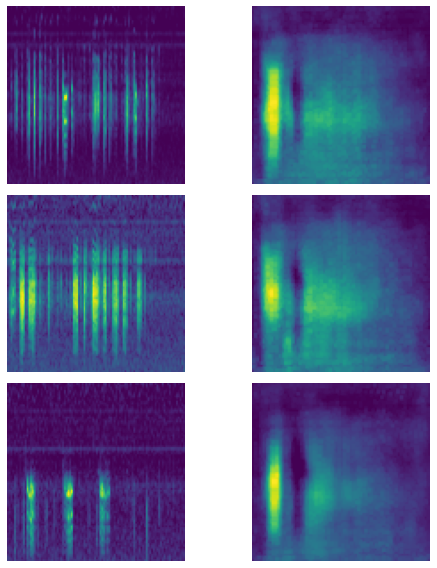

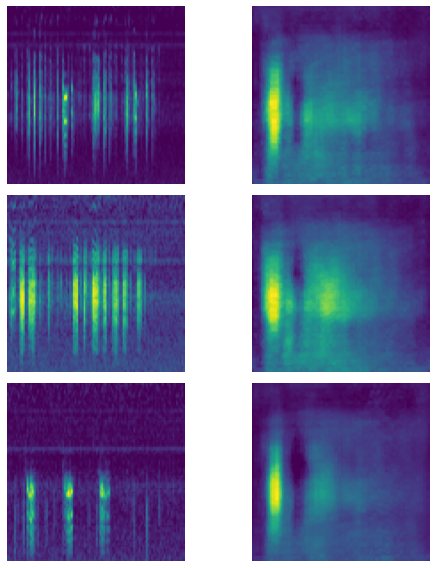

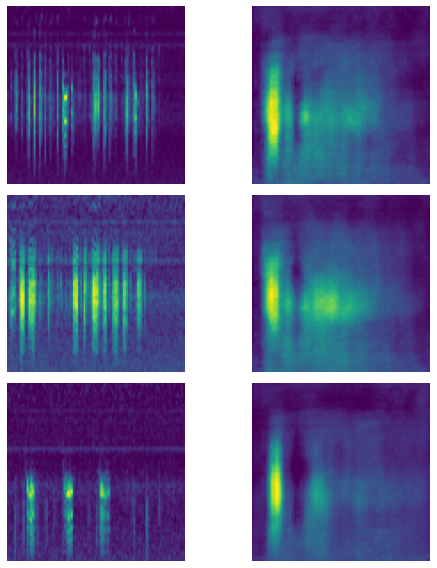

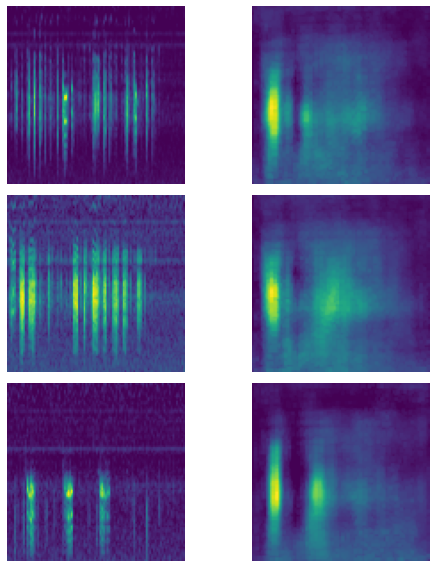

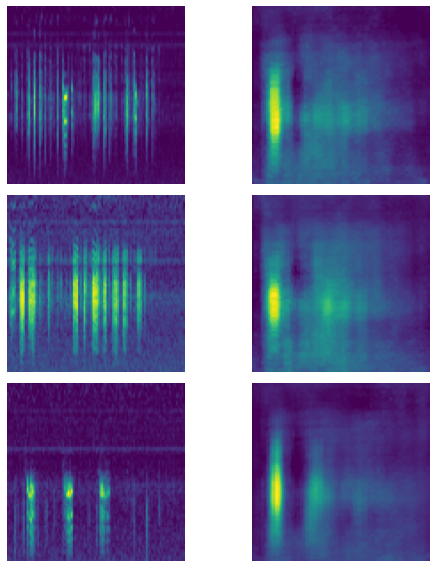

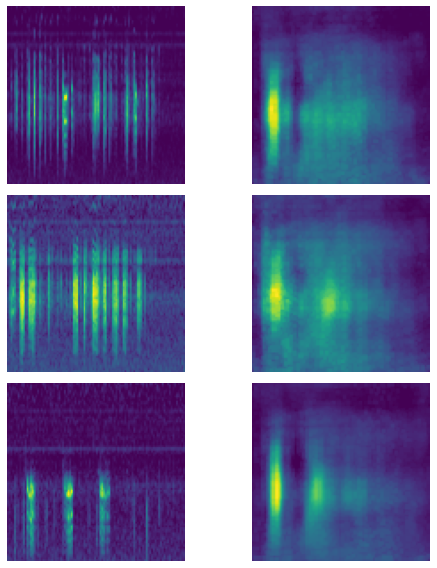

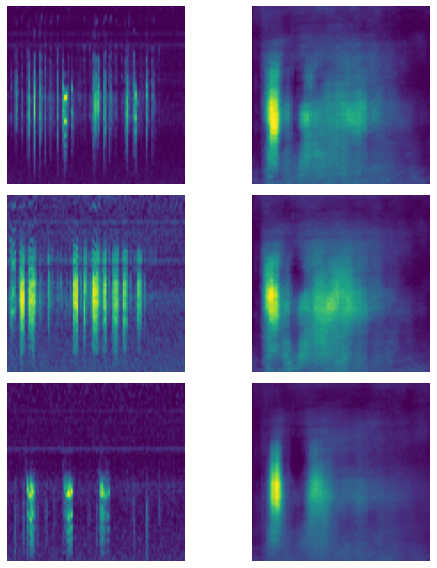

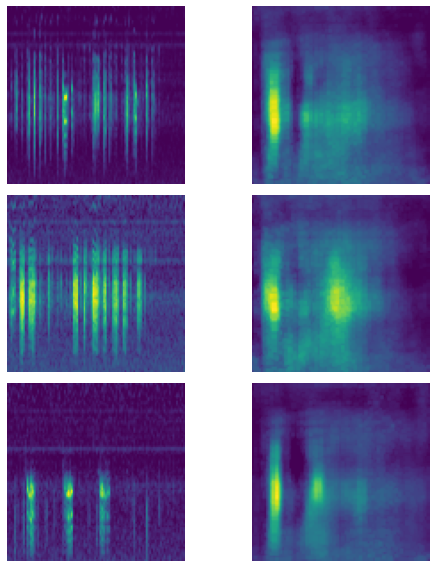

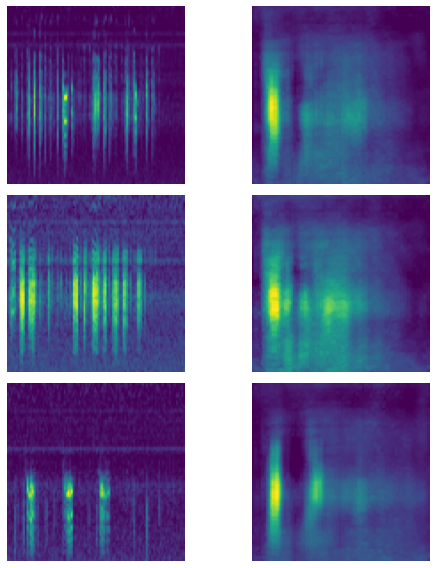

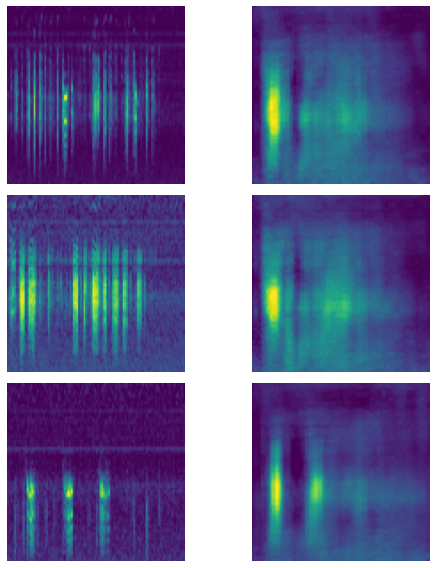

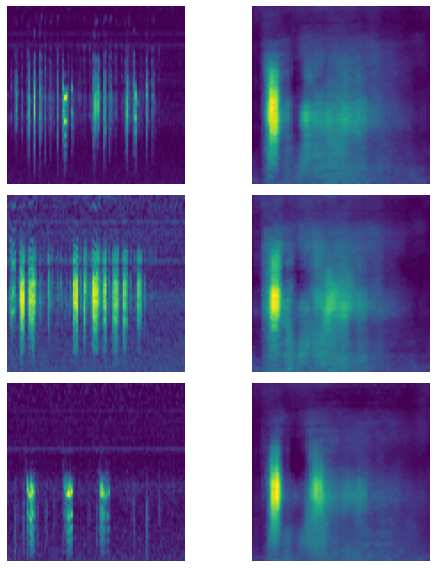

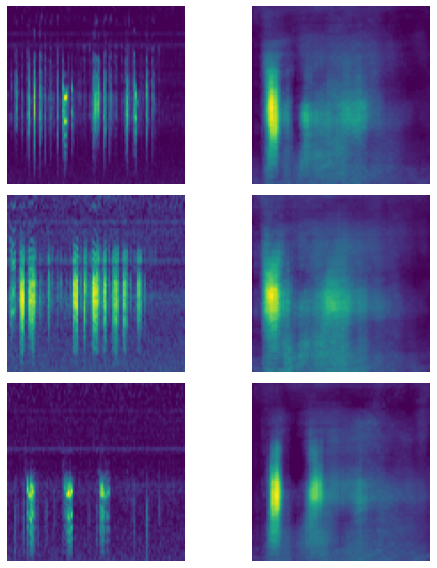

In [95]:
cu_learner.fit_one_cycle(20, 2e-6)

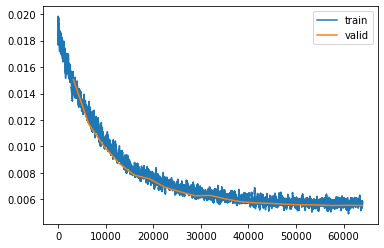

In [97]:
cu_learner.recorder.plot_loss()

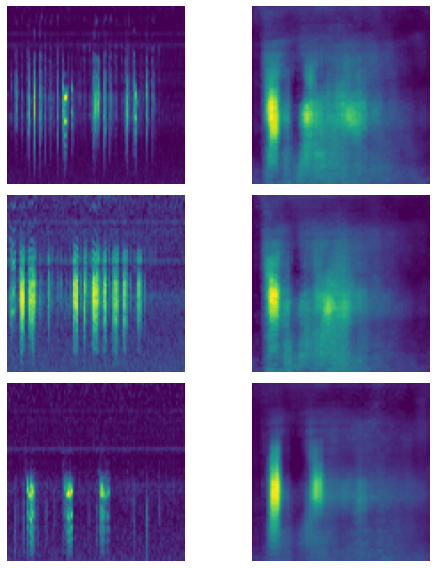

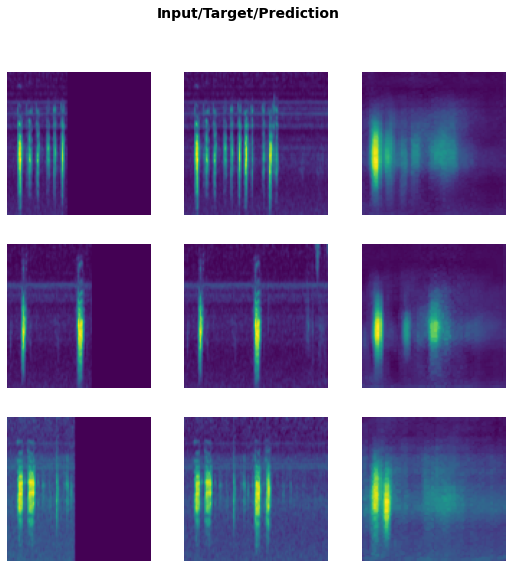

In [98]:
cu_learner.show_results()